In [1]:
import math
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys

mpl.rc('image', cmap='gray')
sys.path.append('..')

from cnsproject.network.connections import (
    ConvolutionalConnection,
    PoolingConnection
)
from cnsproject.network.neural_populations import (
    LIFPopulation,
    InputPopulation
)
from cnsproject.encoding.encoders import Time2FirstSpikeEncoder
from cnsproject.network.monitors import Monitor
from cnsproject.network.network import Network
from cnsproject.filtering.filters import gabor_filter
from cnsproject.utils import read_images

%matplotlib inline

In [2]:
def run_simulation(image, conv_filter, **kwargs):
    sim_time: int = kwargs.get("sim_time", 8)
    conv_th: int = kwargs.get("conv_th", -57)
    max_th: int = kwargs.get("max_th", -59)
    c_shape: tuple = kwargs.get("c_shape", (100 ,100))
    m_shape: tuple = kwargs.get("m_shape", (50, 50))
    conv_k_size: int = kwargs.get("conv_k_size", 13)
    pool_k_size: int = kwargs.get("pool_k_size", 2)
    m_stride: int = kwargs.get("m_stride")
    c_stride: int = kwargs.get("c_stride", 1)
    in_layer = InputPopulation((image.shape[0], image.shape[1]))
    conv_layer = LIFPopulation(c_shape, tau=np.inf, threshold=conv_th)
    max_layer = LIFPopulation(m_shape, tau=np.inf, threshold=max_th)
    conv_monitor = Monitor(conv_layer, state_variables=["s"])
    max_monitor = Monitor(max_layer, state_variables=["s"])
    conv_connection = ConvolutionalConnection(in_layer, conv_layer,
                                              kernel_size=conv_k_size,
                                              padding="valid",
                                              strides=c_stride,
                                              w=conv_filter, wmin=-1., wmax=1.)
    max_connection = PoolingConnection(conv_layer, max_layer,
                                       strides=m_stride,
                                       kernel_size=pool_k_size)
    t2fs_encoder = Time2FirstSpikeEncoder(sim_time, data_max_val=1.)
    encoded = t2fs_encoder(image)
    net = Network()
    net.add_layer(in_layer, "in_layer")
    net.add_layer(conv_layer, "conv_layer")
    net.add_layer(max_layer, "max_layer")
    net.add_connection(conv_connection, "in_layer", "conv_layer")
    net.add_connection(max_connection, "conv_layer", "max_layer")
    net.add_monitor(conv_monitor, "conv_monitor")
    net.add_monitor(max_monitor, "max_monitor")
    net.reset_state_variables()
    conv_curr = torch.zeros(sim_time, *conv_layer.shape)
    max_curr = torch.zeros(sim_time, *max_layer.shape)
    input_dict = dict(in_layer=encoded, conv_layer=conv_curr, max_layer=max_curr)
    net.run(sim_time, current_inputs=input_dict)

    return net, encoded

def draw_plots(
        s_conv,
        s_max,
        encoded,
        title: str = None,
        figsize=(12, 5)
):
    fig, axs = plt.subplots(3, len(s_conv), figsize=figsize)
    ax = axs[0]
    ax[0].set_ylabel('Input(Encoding)')
    for i in range(len(s_conv)):
        ax[i].imshow(encoded[i])
    ax = axs[1]
    ax[0].set_ylabel('Convolution')
    for i in range(-1, len(s_conv) - 1):
        ax[i].imshow(s_conv[i + 1])
    ax = axs[2]
    ax[0].set_ylabel('Max-Pooling')
    for i in range(-2, len(s_conv) - 2):
        ax[i].imshow(s_max[i + 2])
    for i in range(len(ax)):
        ax[i].set_xlabel(f'${i}ms$')

    for ax in axs:
        for i in range(len(ax)):
            ax[i].set_yticks([])
            ax[i].set_xticks([])
    if title is None:
        title = 'Simulation Outputs'
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

def run_sim_draw_plots(image, kernel, title=None, **kwargs):
    if kernel is not None:
        kernel = torch.tensor(kernel)
    net, encoded = run_simulation(
        image,
        conv_filter=kernel,
        **kwargs
    )
    s_conv = net.monitors.get("conv_monitor").get("s")
    s_max = net.monitors.get("max_monitor").get("s")
    draw_plots(s_conv, s_max, encoded, title=title)
    return net

def draw_filter(mat):
    fig, ax = plt.subplots(1, figsize=(1, 1))
    ax.matshow(mat)
    ax.set_yticks([])
    ax.set_xticks([])
    plt.title('Gabor Filter', fontdict={'size': 9})
    plt.show()

In [3]:
images = read_images("images", (112, 112))
images_tensor = torch.tensor(images, dtype=torch.float32)

# Introduction

In this project, we implement Convolutional and Pooling connections.
In pooling layer, each neuron can only spike once. The input is a raw
grayscale image encoded using `Time-to-First-Spike` encoder. In each iteration
the filter of the convolution layer
 will be convolved over the input of that
iteration, and the output will be added to the neurons' voltage in the that layer.
Finally, the spikes of the conv-layer neurons (`simple cells`)
 will connect to pooling-layer neurons (`complex cells`).

In the first part we investigate the effect of neurons' thresholds in both
convolution and pooling layers which represent `Simple cells` and `Complex cells`
 in the brain. Then in the second part, we investigate the
effect of convolution and pooling parameters. (stride and kernel-size).

The filter we use is a gabor filter with two orientations
($0^{\circ}$ and $45^{\circ}$). Other parameters of the filter
are as follows:

$FilterSize = 13\times13$ (default)
$, \sigma=3$
$, \gamma=1$
$, \lambda=2.5\pi$


**Default neurons' parameters:**


1. Convolution layer:

    * $u_{rest} = -60mv$

    * $threshold = -57mv$

    * $tau=inf$ (no decay)

    * $r=1$

2. Pooling layer:

    * $u_{rest} = -60mv$

    * $threshold = -59mv$

    * $tau=inf$ (no decay)

    * $r=1$


**Default Convolution and Pooling params:**

1. Convolution:

    * $Stride = 1\times1$

2. Pooling:

    * $KernelSize=2\times2$

    * $Stride=2\times2 (=KernelSize)$

Note: In all plots we shift the convolution outputs by one step, and the
pooling outputs by two steps to the left. The reason is that this way we can
better see what each layer is doing.


# Part 1 (Neurons' thresholds)

## $Convolution_{threshold}$

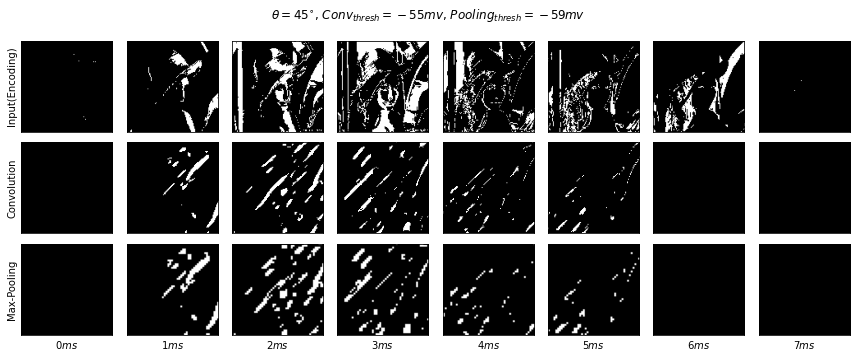

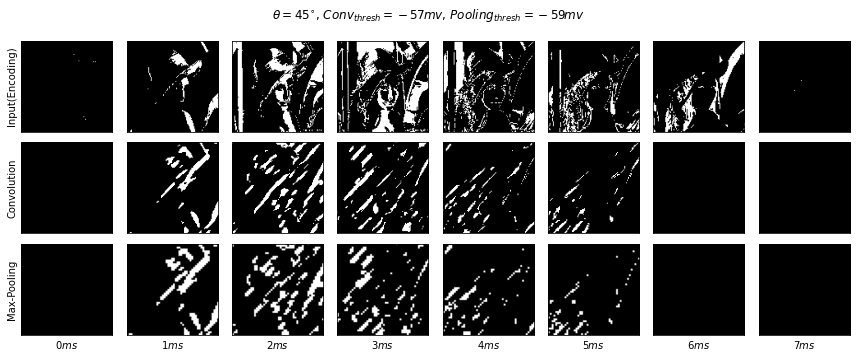

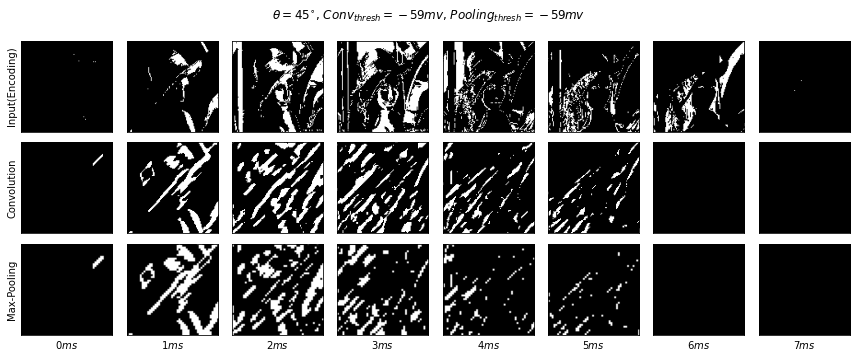

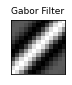

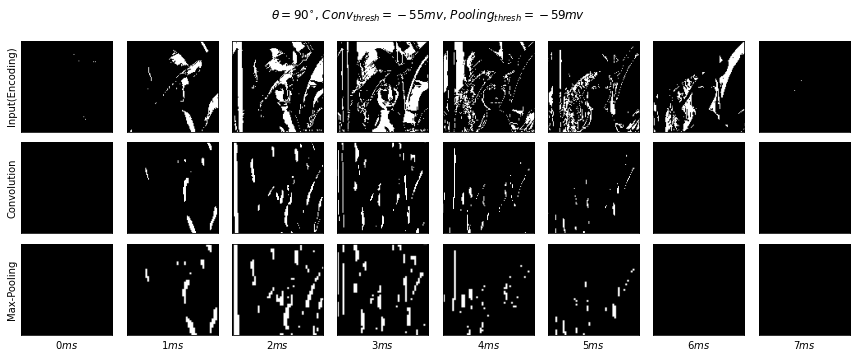

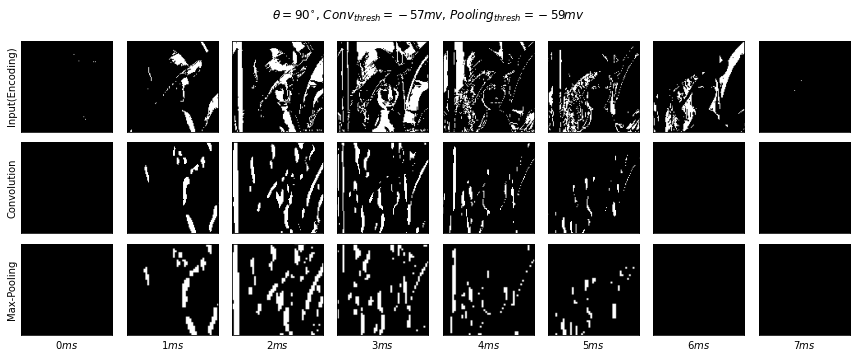

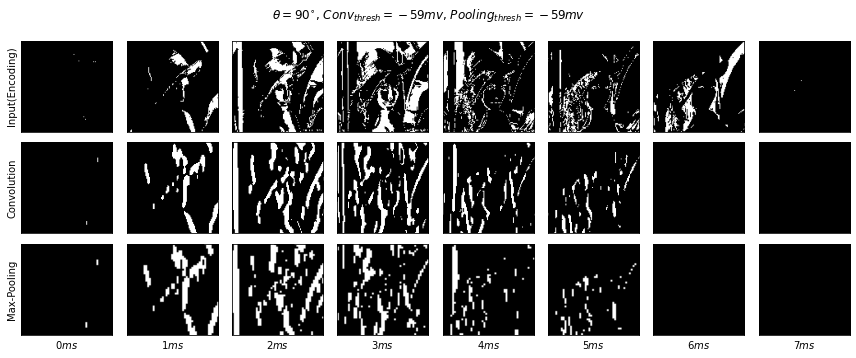

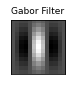

In [4]:

for th in [45, 90]:
    kernel = gabor_filter(13, 3, 1, 2.5 * math.pi, th)
    kernel = torch.tensor(kernel, dtype=torch.float32)
    for conv_th in [-55, -57, -59]:
        net, encoded = run_simulation(
            images_tensor[1], kernel,
            sim_time=8,
            max_th=-59, conv_th=conv_th,
            c_shape=(100, 100), m_shape=(50, 50),
            conv_k_size=13, pool_k_size=2,
        )
        title = rf"$\theta={th}^{{\circ}}$" \
                rf", $Conv_{{thresh}}={conv_th}mv$, $Pooling_{{thresh}}=-59mv$"
        s_conv = net.monitors.get("conv_monitor").get("s")
        s_max = net.monitors.get("max_monitor").get("s")
        draw_plots(s_conv, s_max, encoded, title=title)
    draw_filter(net.connections.get("in_layer_to_conv_layer").w)


By lowering the threshold of convolution layer, some parts of the input that are
not very similar to the filter also make the neurons spike. This is not desirable
as it makes the output of the convolution layer prone to noise.
However, if we set the threshold too high, only strong stimulus will activate
the neurons, and we might lose some information in the early time steps.

## $Pooling_{threshold}$

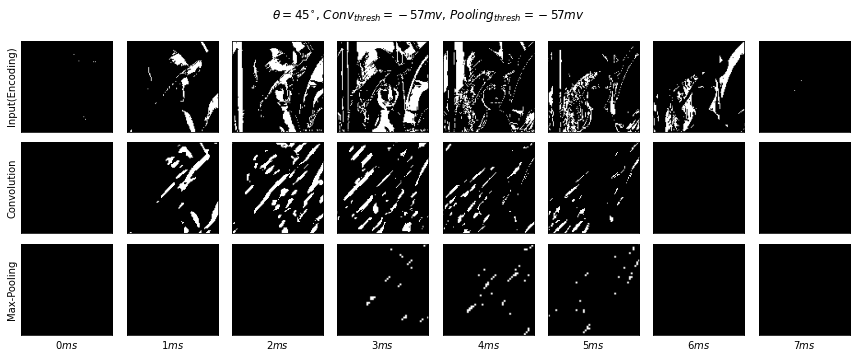

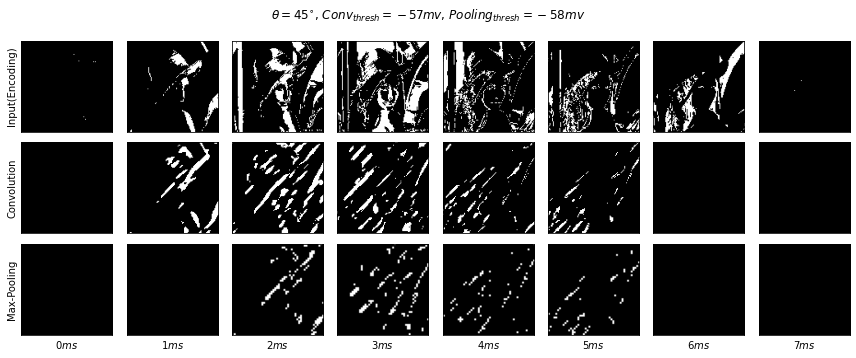

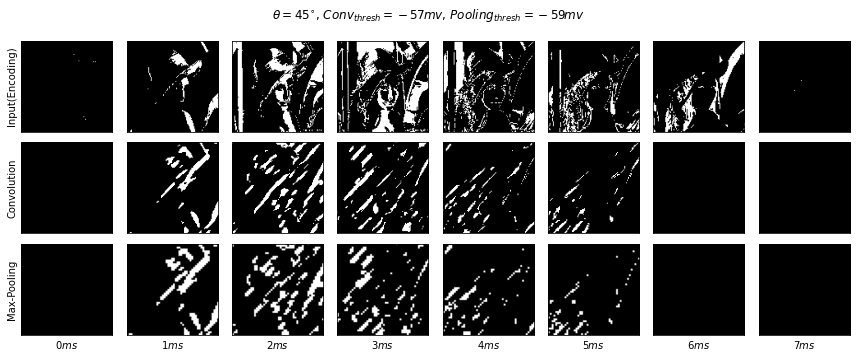

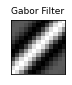

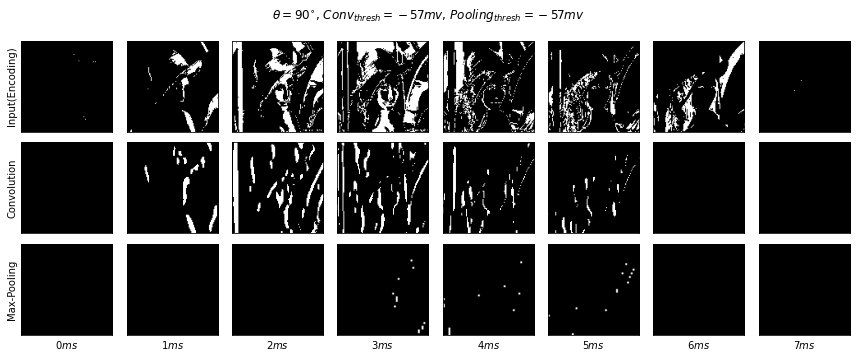

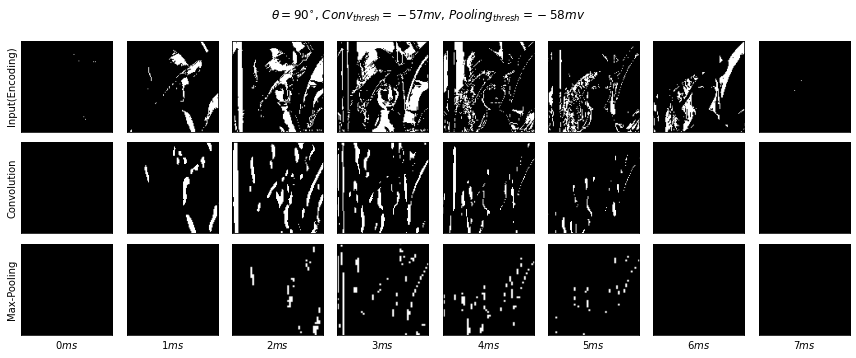

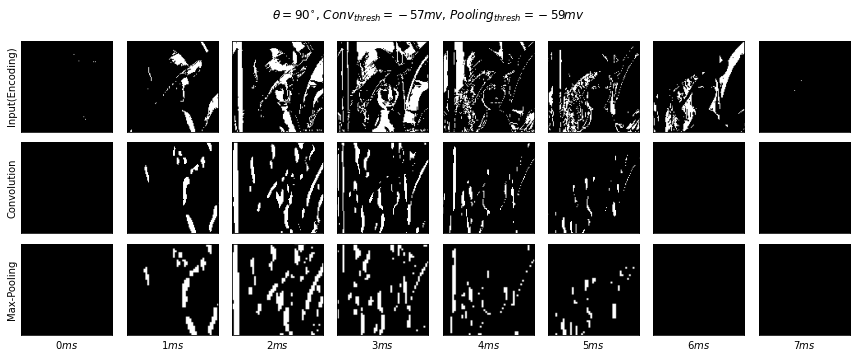

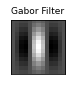

In [5]:
for th in [45, 90]:
    kernel = gabor_filter(13, 3, 1, 2.5 * math.pi, th)
    kernel = torch.tensor(kernel, dtype=torch.float32)
    for max_th in [-57, -58, -59]:
        net, encoded = run_simulation(
            images_tensor[1], kernel,
            sim_time=8,
            max_th=max_th, conv_th=-57,
            c_shape=(100, 100), m_shape=(50, 50),
            conv_k_size=13, pool_k_size=2,
        )
        title = rf"$\theta={th}^{{\circ}}$" \
                rf", $Conv_{{thresh}}=-57mv$, $Pooling_{{thresh}}={max_th}mv$"
        s_conv = net.monitors.get("conv_monitor").get("s")
        s_max = net.monitors.get("max_monitor").get("s")
        draw_plots(s_conv, s_max, encoded, title=title)
    draw_filter(net.connections.get("in_layer_to_conv_layer").w)

The effect of increasing threshold for Pooling neurons is not very different
from the previous case. However, the input to the pooling neurons are
only spikes (binary values). So, if we set the threshold to 2 units above $u_{rest}$,
it means that 2 pre-synaptic neurons have to spike in order for the pooling
neuron to spike. This way, much useful information will be lost. So, it's better
to keep the pooling neurons' threshold to 1 unit above $u_{rest}$ and change the
convolution layer neurons' threshold. Another important thing to consider is
that in the brain, complex cells that here we simulate them using max-pooling,
will be activated when only one of the neurons in their receptive field spike.
So, by setting the complex cell's threshold to 2, we are violating what is actually
happening in the brain.

## Both

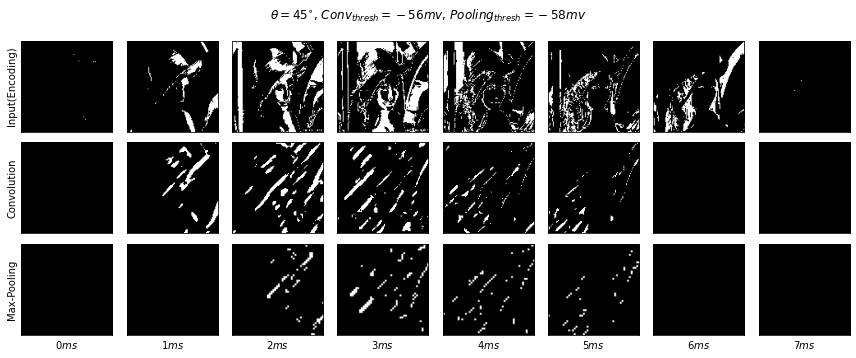

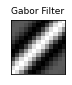

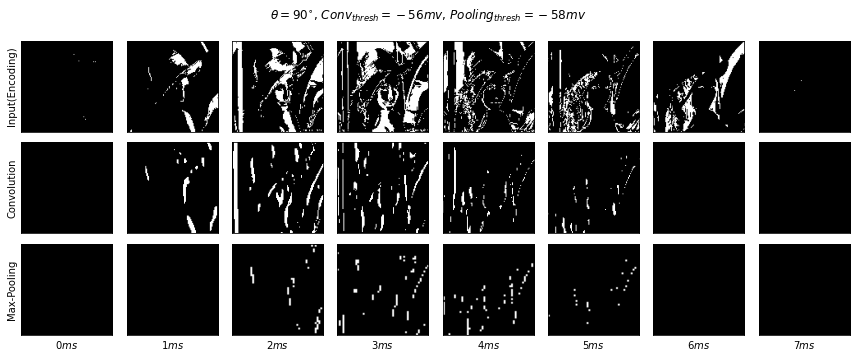

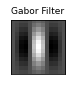

In [6]:
for th in [45, 90]:
    kernel = gabor_filter(13, 3, 1, 2.5 * math.pi, th)
    kernel = torch.tensor(kernel, dtype=torch.float32)
    net, encoded = run_simulation(
        images_tensor[1], kernel,
        sim_time=8,
        max_th=-58, conv_th=-56,
        c_shape=(100, 100), m_shape=(50, 50),
        conv_k_size=13, pool_k_size=2,
    )
    title = rf"$\theta={th}^{{\circ}}$" \
            rf", $Conv_{{thresh}}=-56mv$, $Pooling_{{thresh}}=-58mv$"
    s_conv = net.monitors.get("conv_monitor").get("s")
    s_max = net.monitors.get("max_monitor").get("s")
    draw_plots(s_conv, s_max, encoded, title=title)
    draw_filter(net.connections.get("in_layer_to_conv_layer").w)

# Part 2 (Convolution and Pooling Parameters)

## Convolution Params

### KernelSize

**Note:**  When
the receptive field is smaller, lower amount of activity accumulates in one
convolution layer neuron, so the output will be more sparse. To reduce this effect
we change
$Convolution_{threshold}$ for $FilterSize=5$ from $-57mv$ to $-58mv$.

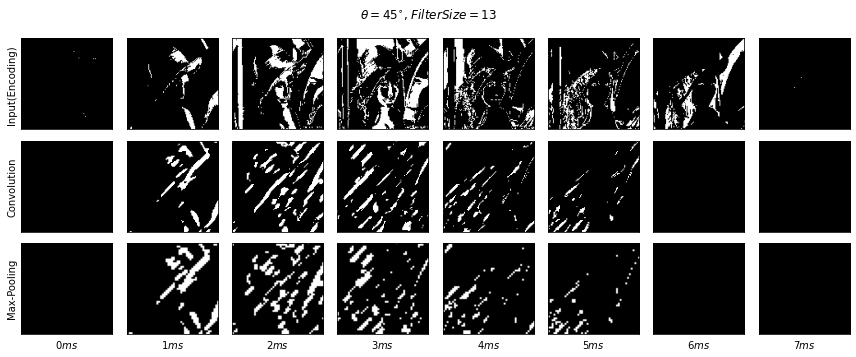

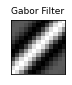

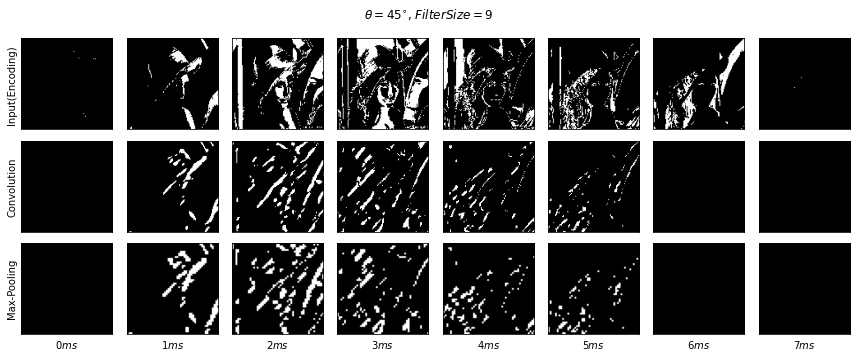

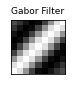

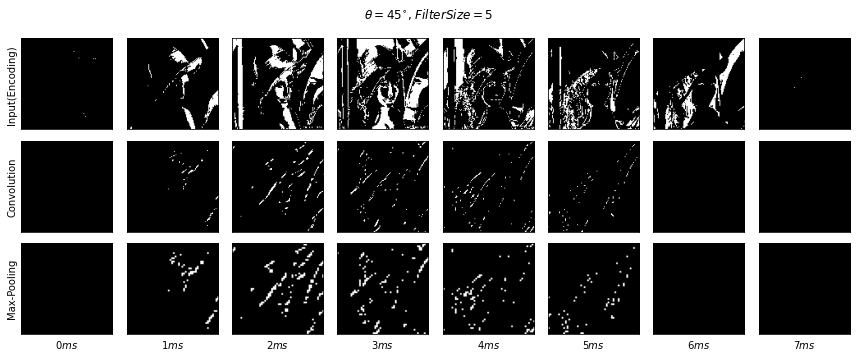

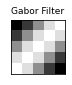

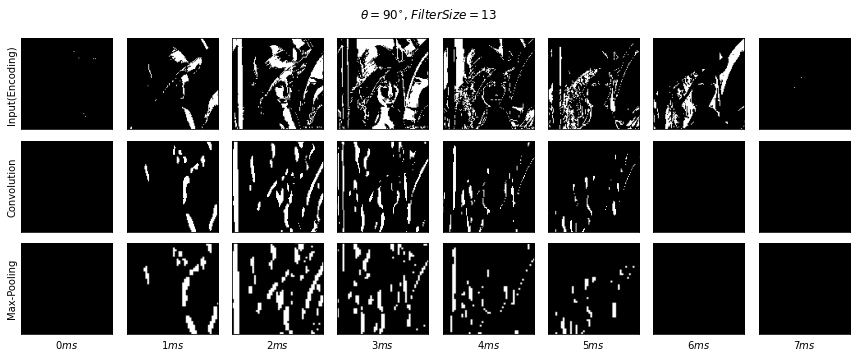

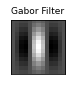

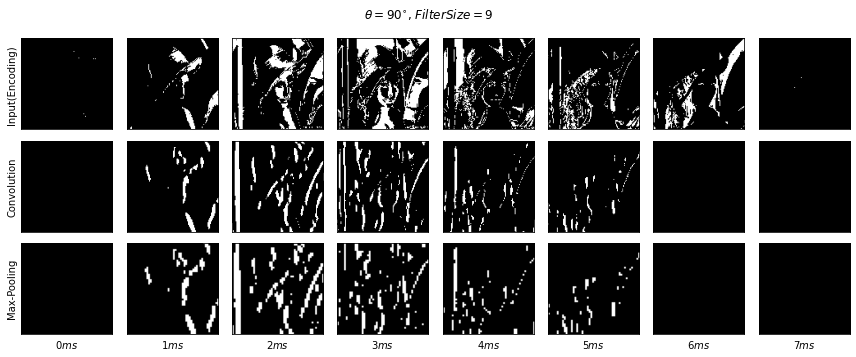

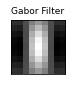

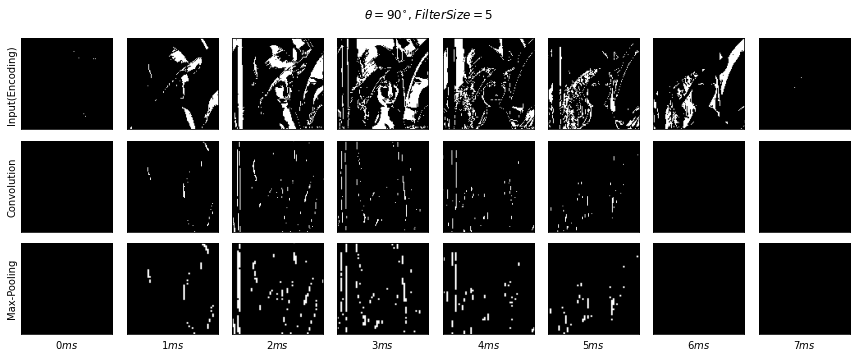

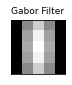

In [7]:
for th in [45, 90]:
    kernel = gabor_filter(13, 3, 1, 2.5 * math.pi, th)
    kernel = torch.tensor(kernel, dtype=torch.float32)
    net, encoded = run_simulation(
        images_tensor[1], kernel,
        sim_time=8,
        c_shape=(100, 100), m_shape=(50, 50),
        conv_k_size=13, pool_k_size=2,
    )
    title = rf"$\theta={th}^{{\circ}}$" \
    rf", $FilterSize={13}$"
    s_conv = net.monitors.get("conv_monitor").get("s")
    s_max = net.monitors.get("max_monitor").get("s")
    draw_plots(s_conv, s_max, encoded, title=title)
    draw_filter(net.connections.get("in_layer_to_conv_layer").w)

    kernel = gabor_filter(9, 3, 1, 2.5 * math.pi, th)
    kernel = torch.tensor(kernel, dtype=torch.float32)
    net, encoded = run_simulation(
        images_tensor[1], kernel,
        sim_time=8,
        c_shape=(104, 104), m_shape=(52, 52),
        conv_k_size=9, pool_k_size=2,
        conv_th=-57.5
    )
    title = rf"$\theta={th}^{{\circ}}$" \
    rf", $FilterSize={9}$"
    s_conv = net.monitors.get("conv_monitor").get("s")
    s_max = net.monitors.get("max_monitor").get("s")
    draw_plots(s_conv, s_max, encoded, title=title)
    draw_filter(net.connections.get("in_layer_to_conv_layer").w)

    kernel = gabor_filter(5, 3, 1, 2.5 * math.pi, th)
    kernel = torch.tensor(kernel, dtype=torch.float32)
    net, encoded = run_simulation(
        images_tensor[1], kernel,
        sim_time=8,
        c_shape=(108, 108), m_shape=(54, 54),
        conv_k_size=5, pool_k_size=2,
        conv_th=-58,
    )
    title = rf"$\theta={th}^{{\circ}}$" \
    rf", $FilterSize={5}$"
    s_conv = net.monitors.get("conv_monitor").get("s")
    s_max = net.monitors.get("max_monitor").get("s")
    draw_plots(s_conv, s_max, encoded, title=title)
    draw_filter(net.connections.get("in_layer_to_conv_layer").w)

Smaller kernels detect smaller lines and larger kernels detect larger lines.

### Stride

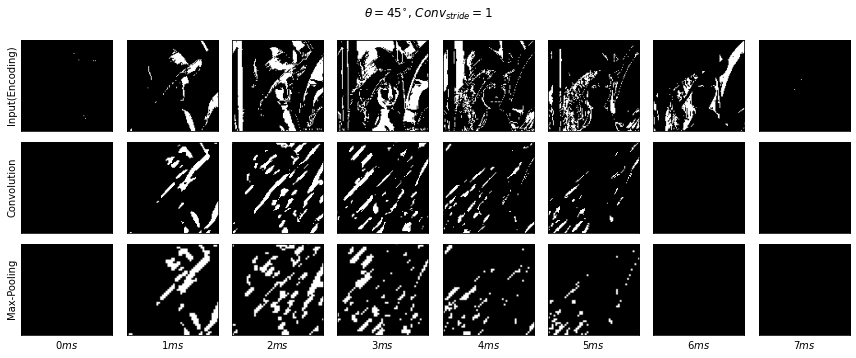

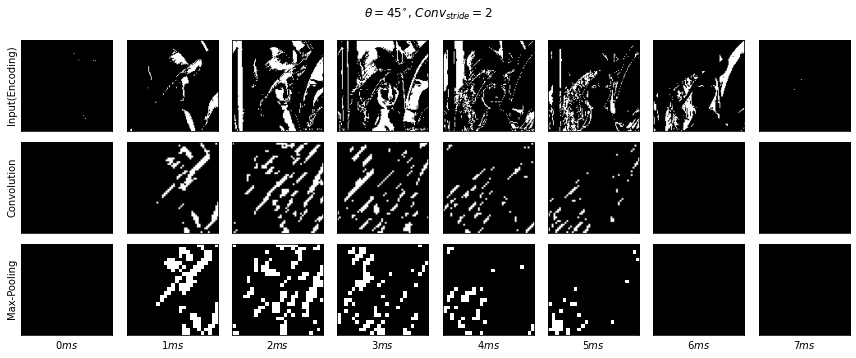

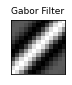

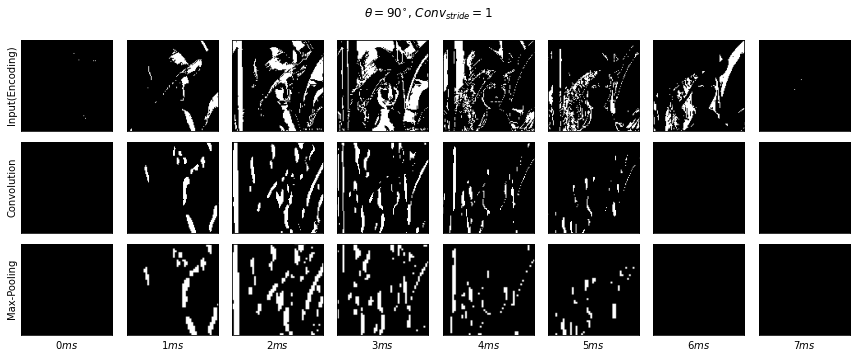

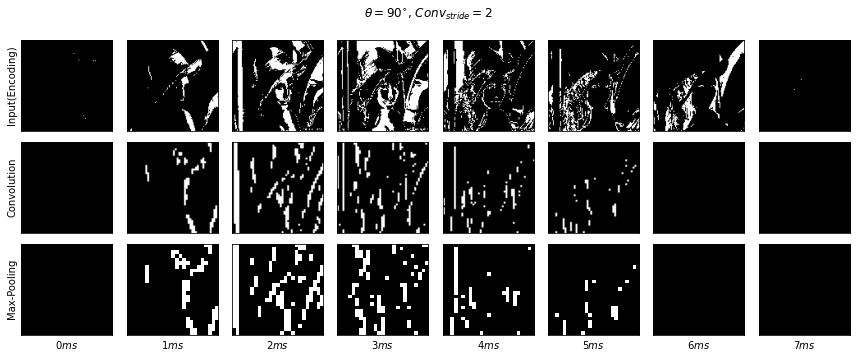

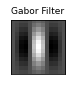

In [8]:
for th in [45, 90]:
    kernel = gabor_filter(13, 3, 1, 2.5 * math.pi, th)
    kernel = torch.tensor(kernel, dtype=torch.float32)
    net, encoded = run_simulation(
        images_tensor[1], kernel,
        sim_time=8,
        c_shape=(100, 100), m_shape=(50, 50),
        conv_k_size=13, pool_k_size=2,
    )
    title = rf"$\theta={th}^{{\circ}}$" \
            rf", $Conv_{{stride}}={1}$"
    s_conv = net.monitors.get("conv_monitor").get("s")
    s_max = net.monitors.get("max_monitor").get("s")
    draw_plots(s_conv, s_max, encoded, title=title)

    net, encoded = run_simulation(
        images_tensor[1], kernel,
        sim_time=8,
        c_shape=(50, 50), m_shape=(25, 25),
        conv_k_size=13, pool_k_size=2,
        c_stride=2
    )
    title = rf"$\theta={th}^{{\circ}}$" \
            rf", $Conv_{{stride}}={2}$"
    s_conv = net.monitors.get("conv_monitor").get("s")
    s_max = net.monitors.get("max_monitor").get("s")
    draw_plots(s_conv, s_max, encoded, title=title)
    draw_filter(net.connections.get("in_layer_to_conv_layer").w)

We see that by increasing the stride of convolution, an operation similar to
max-pooling is taking place, and the convolution output is also downsampled.
 By setting $Conv_{{stride}}={2\times2}$,
 the output shape of the convolution layer will be halved in each direction.

If we compare the output of max-pooling layer with $Conv_{stride}=1\times1$
and the output of convolution layer with $Conv_{stride}=2\times2$, the similarity
between the two will be obvious. Note that the two outputs also have the same

**Note:**
Stride of convolution is modeling the `density` of simple cells, so it's better
to keep the stride as low as possible (=1). This also makes our model
as biologically plausible as we can (In V1 layer simple cells are very dense).

## Pooling Params

In pooling layer KernelSize models the `receptive field` of `Complex cells` and
Stride models the `density` of these neurons.

### $KernelSize>Stride$


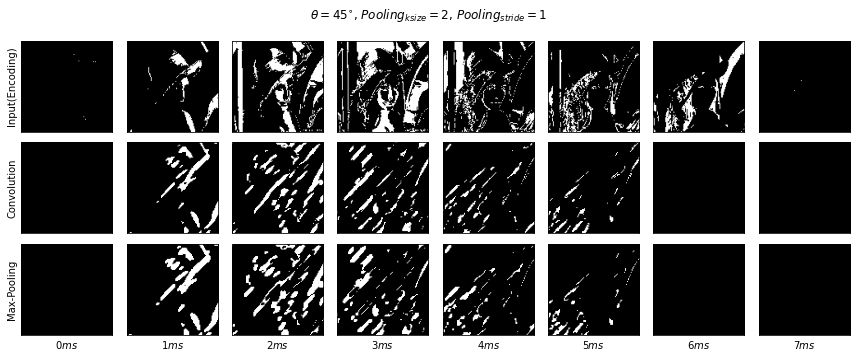

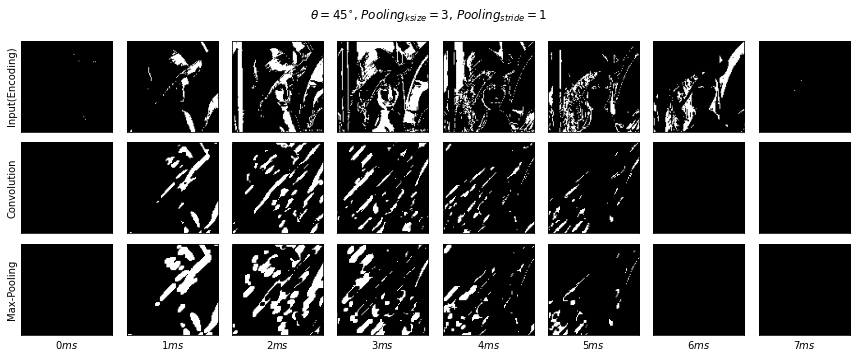

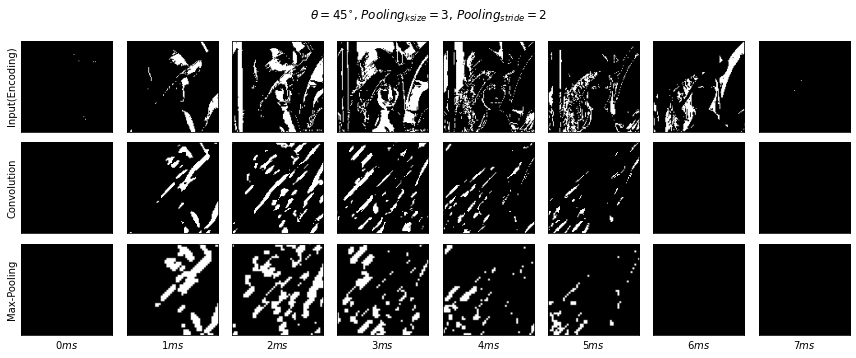

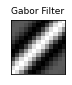

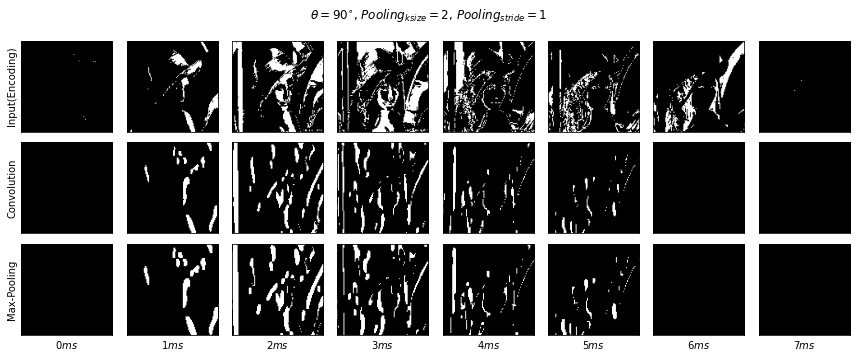

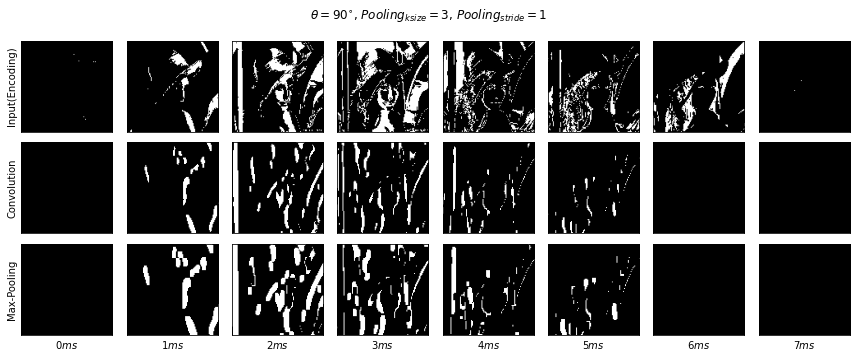

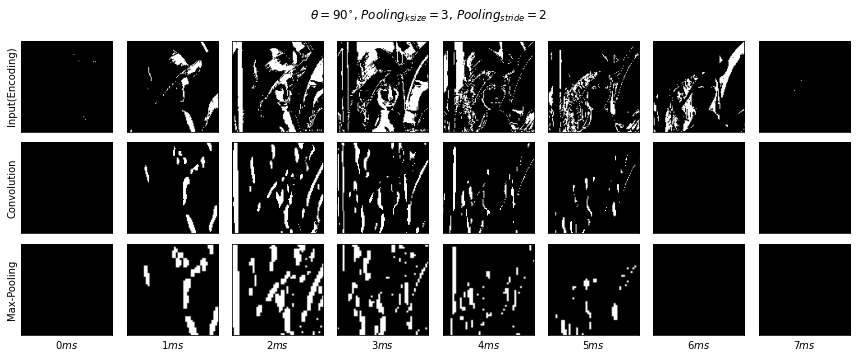

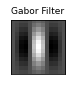

In [9]:
for th in [45, 90]:
    kernel = gabor_filter(13, 3, 1, 2.5 * math.pi, th)
    kernel = torch.tensor(kernel, dtype=torch.float32)
    net, encoded = run_simulation(
        images_tensor[1], kernel,
        sim_time=8,
        c_shape=(100, 100), m_shape=(99, 99),
        conv_k_size=13, pool_k_size=2,
        m_stride=1,
    )
    title = rf"$\theta={th}^{{\circ}}$" \
            rf", $Pooling_{{ksize}}={2}$, $Pooling_{{stride}}=1$"
    s_conv = net.monitors.get("conv_monitor").get("s")
    s_max = net.monitors.get("max_monitor").get("s")
    draw_plots(s_conv, s_max, encoded, title=title)

    net, encoded = run_simulation(
        images_tensor[1], kernel,
        sim_time=8,
        c_shape=(100, 100), m_shape=(98, 98),
        conv_k_size=13, pool_k_size=3,
        m_stride=1,
    )
    title = rf"$\theta={th}^{{\circ}}$" \
            rf", $Pooling_{{ksize}}={3}$, $Pooling_{{stride}}=1$"
    s_conv = net.monitors.get("conv_monitor").get("s")
    s_max = net.monitors.get("max_monitor").get("s")
    draw_plots(s_conv, s_max, encoded, title=title)

    net, encoded = run_simulation(
        images_tensor[1], kernel,
        sim_time=8,
        c_shape=(100, 100), m_shape=(49, 49),
        conv_k_size=13, pool_k_size=3,
        m_stride=2,
    )
    title = rf"$\theta={th}^{{\circ}}$" \
            rf", $Pooling_{{ksize}}={3}$, $Pooling_{{stride}}=2$"
    s_conv = net.monitors.get("conv_monitor").get("s")
    s_max = net.monitors.get("max_monitor").get("s")
    draw_plots(s_conv, s_max, encoded, title=title)
    draw_filter(net.connections.get("in_layer_to_conv_layer").w)

$Pooling_{{stride}}={1}$, adds a negligible amount of invariance to the convolution
output and does not change the shape. By increasing the $Pooling_{{ksize}}$ and
fixing the $Pooling_{stride}=1$, we do not gain anything as the shape will
be preserved and no redundant information will be neglected.

If we think of complex cells and simple cells in visual cortex, we may better
understand why $stride=1$ is not doing anything useful.
This is like having some simple cells connected to more than just one complex cell.
 The goal of complex cells
is to add invariance to simple cells' output, but with $stride=1$, and more
generally with $KernelSize>Stride$, this goal
is not achieved.

### $Stride=KernelSize$

From the previous section we saw that using $KernelSize>Stride$ is not
doing what we expect.

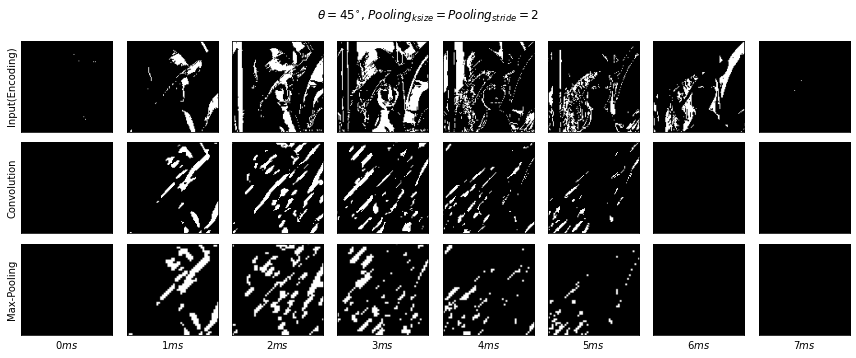

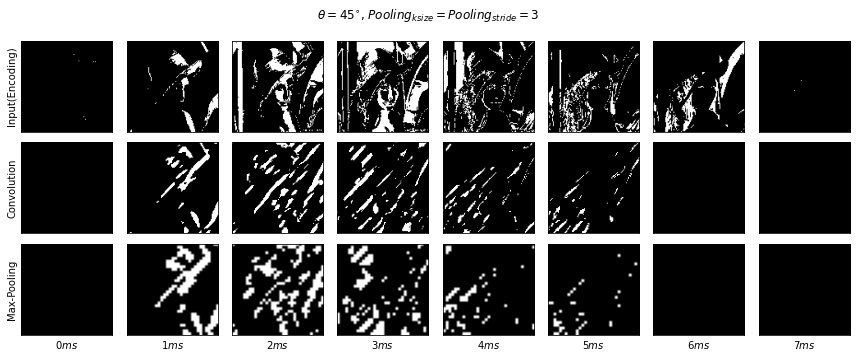

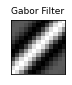

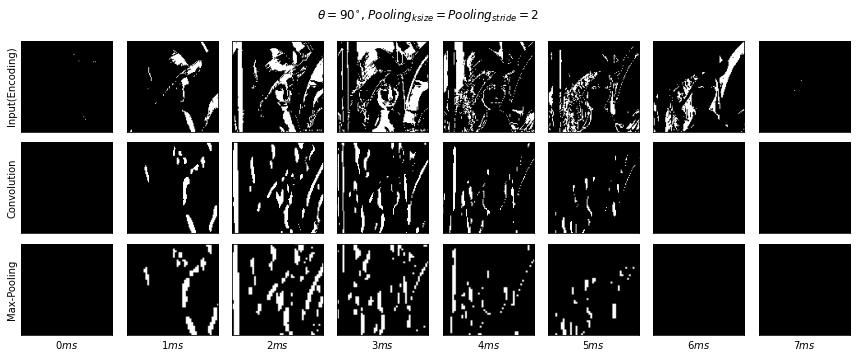

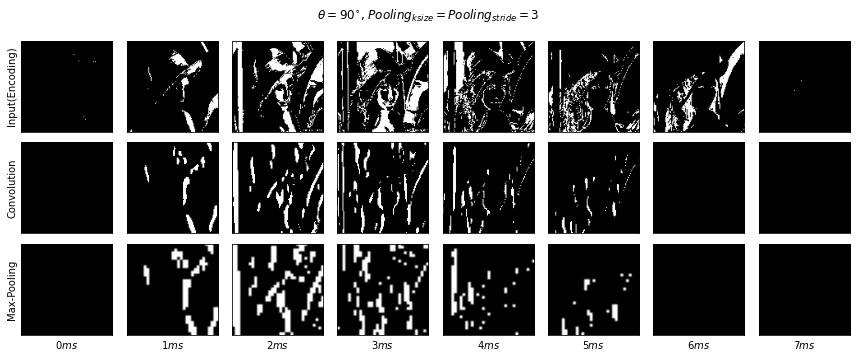

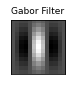

In [10]:
for th in [45, 90]:
    kernel = gabor_filter(13, 3, 1, 2.5 * math.pi, th)
    kernel = torch.tensor(kernel, dtype=torch.float32)
    net, encoded = run_simulation(
        images_tensor[1], kernel,
        sim_time=8,
        c_shape=(100, 100), m_shape=(50, 50),
        conv_k_size=13, pool_k_size=2,
    )
    title = rf"$\theta={th}^{{\circ}}$" \
            rf", $Pooling_{{ksize}}=Pooling_{{stride}}={2}$"
    s_conv = net.monitors.get("conv_monitor").get("s")
    s_max = net.monitors.get("max_monitor").get("s")
    draw_plots(s_conv, s_max, encoded, title=title)

    net, encoded = run_simulation(
        images_tensor[1], kernel,
        sim_time=8,
        c_shape=(100, 100), m_shape=(33, 33),
        conv_k_size=13, pool_k_size=3,
    )
    title = rf"$\theta={th}^{{\circ}}$" \
            rf", $Pooling_{{ksize}}=Pooling_{{stride}}={3}$"
    s_conv = net.monitors.get("conv_monitor").get("s")
    s_max = net.monitors.get("max_monitor").get("s")
    draw_plots(s_conv, s_max, encoded, title=title)
    draw_filter(net.connections.get("in_layer_to_conv_layer").w)

We see that by increasing $Pooling_{{ksize}}$ and $Pooling_{stride}$ together,
the amount of invariance will be increased, and the shape will
be reduced. This is what we expect from a model that mimics the complex cells.
$Pooling_{{ksize}}=Pooling_{stride}=2$ seems to be a good choice here.

### $KernelSize>Stride$

In this case, some input pixels will be neglected altogether. Although the outputs
are not very different from previous section, this setting is **not biologically plausible**
 because it means
that some simple cells are not connected to any complex cells. Therefore, we
do not use this setting for our simulations.

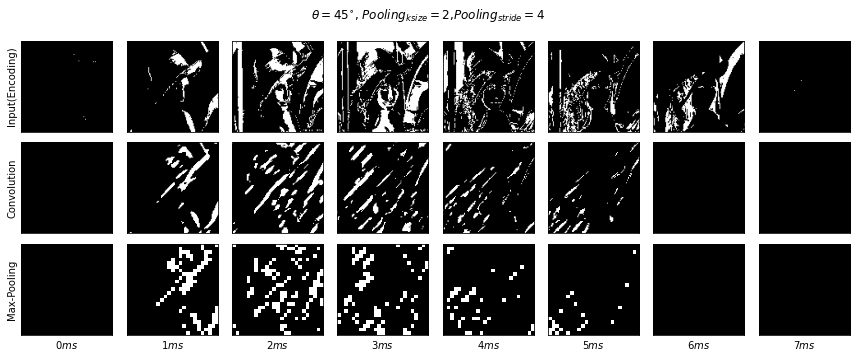

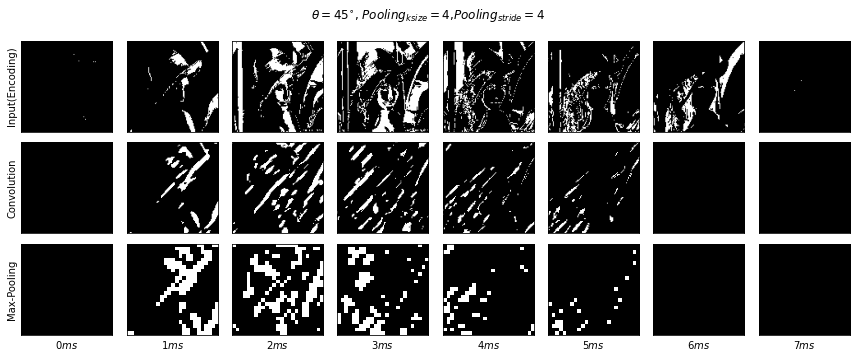

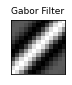

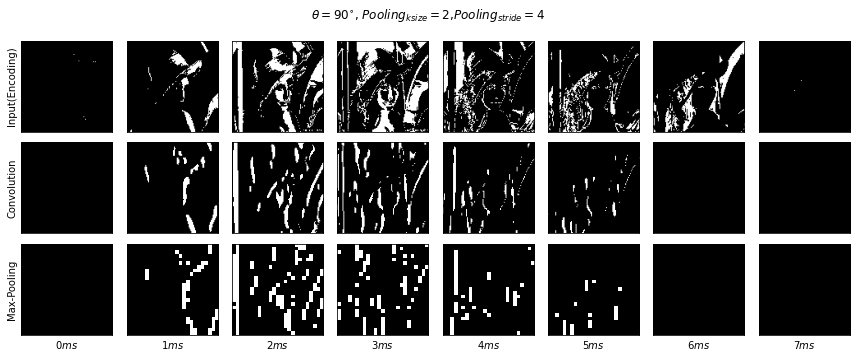

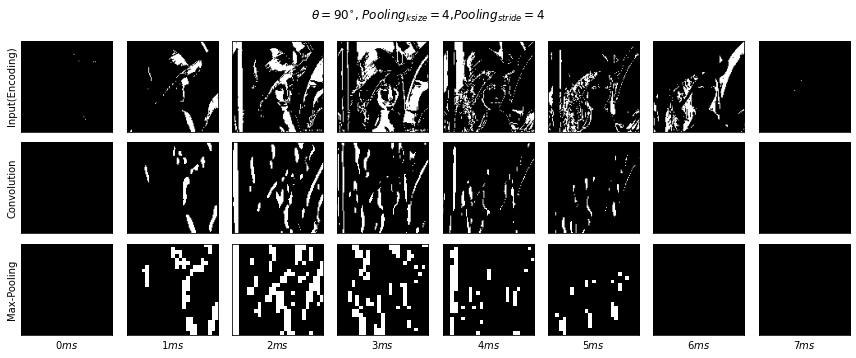

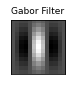

In [11]:
for th in [45, 90]:
    kernel = gabor_filter(13, 3, 1, 2.5 * math.pi, th)
    kernel = torch.tensor(kernel, dtype=torch.float32)
    net, encoded = run_simulation(
        images_tensor[1], kernel,
        sim_time=8,
        c_shape=(100, 100), m_shape=(25, 25),
        conv_k_size=13, pool_k_size=2,
        m_stride=4
    )
    title = rf"$\theta={th}^{{\circ}}$" \
            rf", $Pooling_{{ksize}}=2$,$Pooling_{{stride}}={4}$"
    s_conv = net.monitors.get("conv_monitor").get("s")
    s_max = net.monitors.get("max_monitor").get("s")
    draw_plots(s_conv, s_max, encoded, title=title)
    net, encoded = run_simulation(
        images_tensor[1], kernel,
        sim_time=8,
        c_shape=(100, 100), m_shape=(25, 25),
        conv_k_size=13, pool_k_size=4,
        m_stride=4
    )
    title = rf"$\theta={th}^{{\circ}}$" \
            rf", $Pooling_{{ksize}}=4$,$Pooling_{{stride}}={4}$"
    s_conv = net.monitors.get("conv_monitor").get("s")
    s_max = net.monitors.get("max_monitor").get("s")
    draw_plots(s_conv, s_max, encoded, title=title)
    draw_filter(net.connections.get("in_layer_to_conv_layer").w)

# Summary

1. Model's sensitivity to the input could be controlled by changing convolution
layer neurons (simple cells) threshold. The more the threshold, the model is more
robust to noise. However, too high thresholds make the model to not respond
to some useful information.

2. It's better to keep pooling layer neurons' threshold to 1 unit above their
$u_{rest}$. This is because in brain, complex cells mostly spike when only one
of the simple cells in their receptive field spike. Also, in the simulations,
we saw that setting this parameter to 2, will cause the model to neglect much
useful information.

3. Smaller convolution kernels
 detect smaller lines and larger kernels detect larger lines. Neurons in
 convolution layer with smaller receptive field should have lower threshold
 and vice versa.

4. By increasing the stride of convolution, we are lowering the density of
`simple cells` and the output is similar to the output of applying max pooling.
It's better to keep the $Convolution_{stride}$ as low as possible to have a
 model with more bio plausibility.

5. $Stride$ and $KernelSize$ are better to be equal in the pooling layer. If
$Stride < KernelSize$, the effect of pooling is not clearly visible. If
$Stride > KernelSize$, we are neglecting some neurons in the previous layer
completely, which means that we are loosing useful information. Also, if
we consider complex cells in the visual cortex, $Stride = KernelSize$ is more
biologically plausible because it means that each `simple cell` is
connected to only 1 `complex cell`.
